In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
import pandas 

# collect all our data sets 

tm = pandas.read_csv( '../data_sets/experimental_data/thermo_paper_data_set.csv', index_col=0 )[ [ 'km' ] ]

bench = pandas.read_csv( '../data_sets/features/benchmark_feature_set.csv' )
bench = bench.groupby( 'description' ).apply( lambda x: x.sort_values( 'total_score' ).head( 10 ).mean() ) 

foldx = pandas.read_csv( '../data_sets/features/foldx.csv', index_col=0 )

ddg = pandas.read_csv( '../data_sets/features/ddg_feature_set.csv', index_col=0 )

relax = pandas.read_csv( '../data_sets/features/fast_relax.csv' )
relax = relax.groupby( 'name' ).apply( lambda x: x.sort_values( 'total_score' ).head( 10 ).mean() ) 

In [9]:
feature_sets = [ 
    ( 'RosettaDesign', bench ),
    ( 'FoldX', foldx ), 
    ( 'Rosetta ddG', ddg ), 
    ( 'Rosetta FastRelax', relax ), 
]

In [10]:
# how many features? 

for name, feature_set in feature_sets:
    feature_set = tm.join( feature_set ).dropna()
    print '{1}\t{0}'.format( name, len( feature_set.columns ) ) 

60	RosettaDesign
23	FoldX
15	Rosetta ddG
20	Rosetta FastRelax


In [12]:
# tables of single feature correlations for Tm 

for name, feature_set in feature_sets:
    feature_set = tm.join( feature_set ).dropna()
    print name, 'single feature correlations (PCC)' 
    print feature_set.corr( method='pearson' )[ 'km' ].drop( 'km' ).dropna().sort_values( ascending=False )

RosettaDesign single feature correlations (PCC)
SR_5_hbond_sc            0.329363
SR_1_all_cst             0.258933
SR_3_all_cst             0.258933
SR_3_hbond_pm            0.257909
SR_1_hbond_pm            0.257909
SR_2_hbond_pm            0.242269
SR_5_total_score         0.210934
SR_5_interf_E_1_2        0.210816
hbond_sc                 0.175338
SR_2_hbond_sc            0.055563
tot_total_neg_charges    0.041907
SR_4_hbond_pm            0.030692
SR_5_burunsat_pm         0.030485
SR_4_nlpstat_pm          0.020015
SR_5_all_cst             0.016713
SR_2_pstat_pm            0.007358
SR_4_pstat_pm           -0.007265
SR_2_total_score        -0.016713
fa_rep                  -0.037044
total_score             -0.038973
SR_2_burunsat_pm        -0.042903
SR_4_burunsat_pm        -0.053552
SR_2_nlpstat_pm         -0.070038
tot_burunsat_pm         -0.070948
SR_4_total_score        -0.072201
tot_hbond_pm            -0.095819
SR_5_dsasa_1_2          -0.103277
SR_4_fa_rep             -0.107441


RosettaDesign single feature correlations


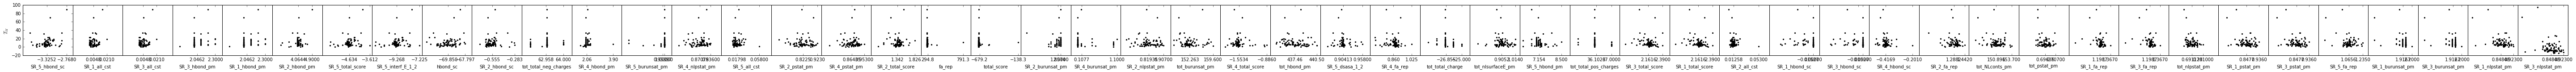

FoldX single feature correlations


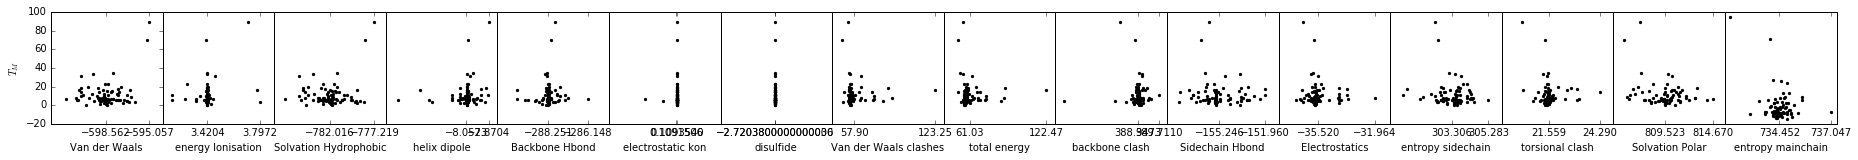

Rosetta ddG single feature correlations


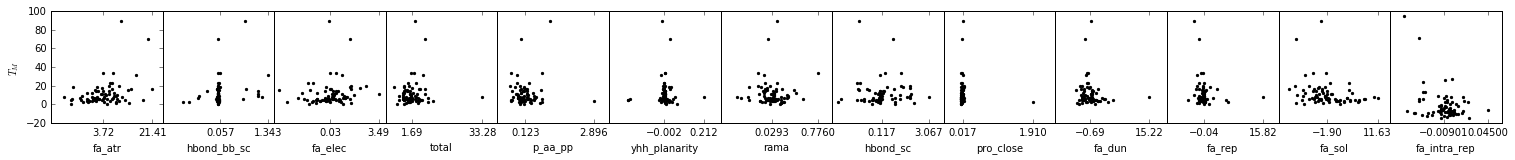

Rosetta FastRelax single feature correlations


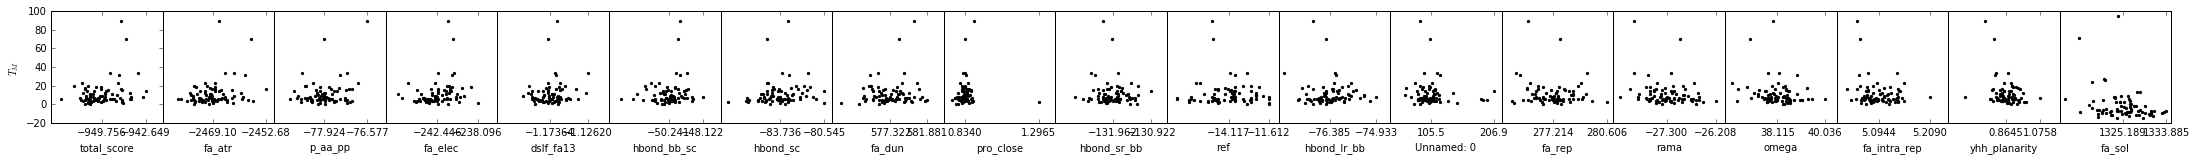

In [14]:
# would be nice to have plots, too

# tables of single feature correlations for Tm 

for name, feature_set in feature_sets:
    feature_set = tm.join( feature_set ).dropna()
    print name, 'single feature correlations' 
    my_corr = feature_set.corr( method='pearson' )[ 'km' ].drop( 'km' ).dropna().sort_values( ascending=False )
    
    n_feats = len( my_corr ) 
    scale_factor = 2 
    plt.figure(figsize=( scale_factor * n_feats, scale_factor ) )
    
    for i, ( feat, value ) in enumerate( my_corr.iteritems() ):
        plt.subplot( 1, n_feats, i+1 )
        plt.scatter( feature_set[ feat ], feature_set[ 'km' ], marker='.', c='k' ) 
        plt.xlabel( feat ) 
        
        plt.xticks( ( feature_set[ feat ].mean(), feature_set[ feat ].max() ) )
        #print feat, value 
        if i == 0:
            plt.ylabel( '$T_M$' ) 
        else:
            plt.yticks( [] )
            
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.locator_params(nbins=2)
    
    plt.show()

RosettaDesign


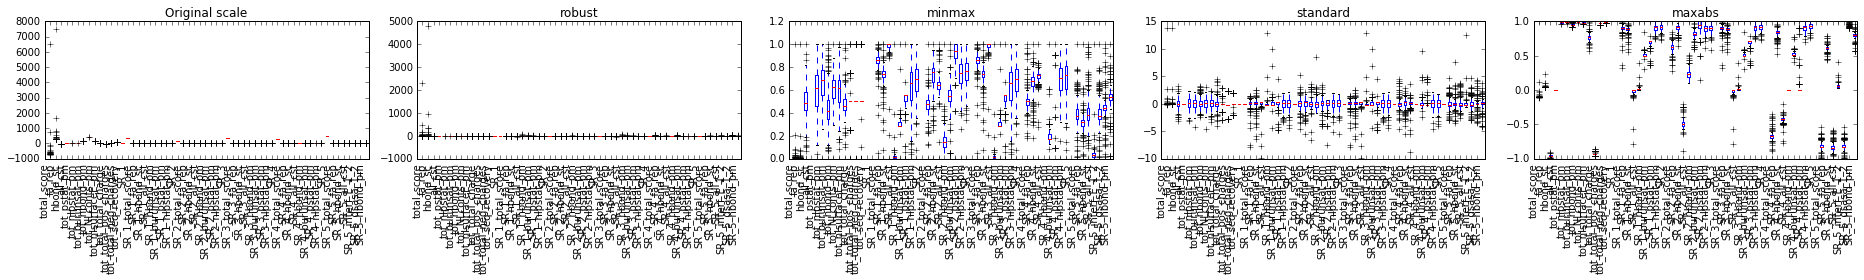

FoldX


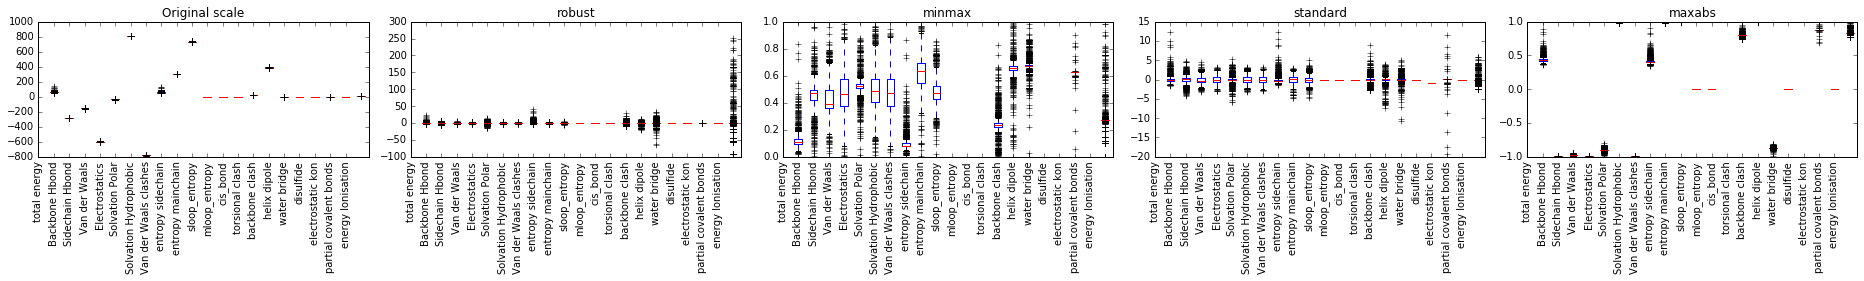

Rosetta ddG


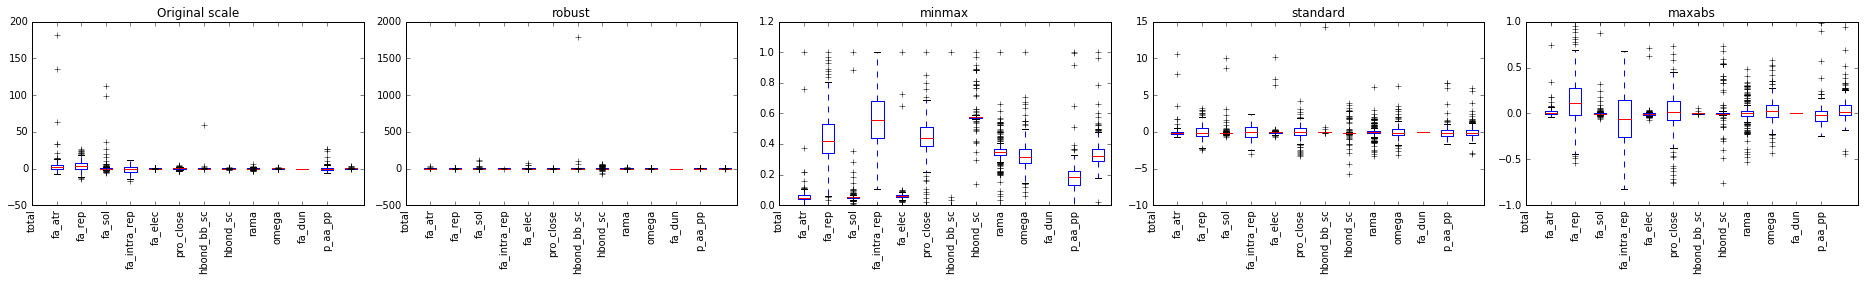

Rosetta FastRelax


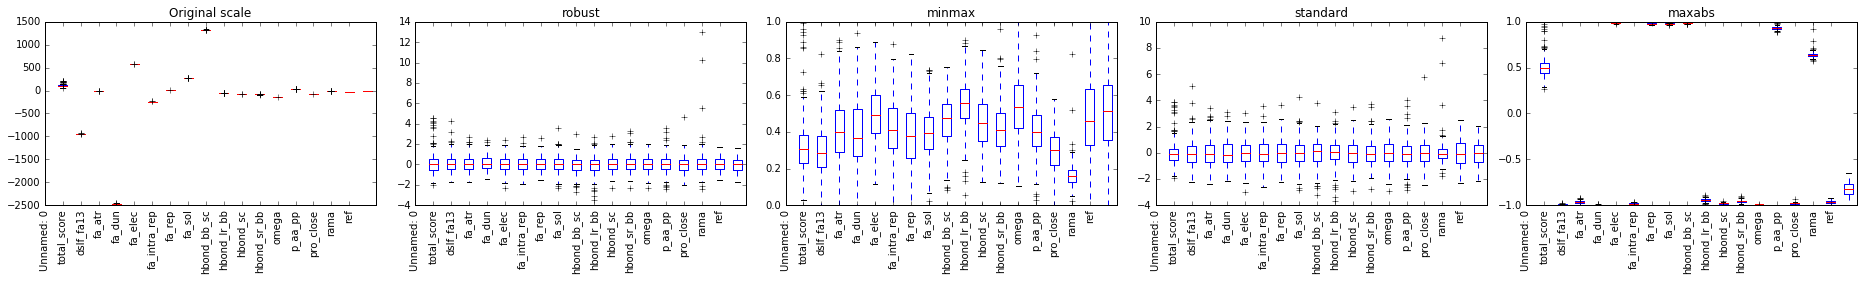

In [15]:
# investigate different scaling methods 

from sklearn import preprocessing

scalers = [ 
    ( 'robust', preprocessing.RobustScaler() ), 
    ( 'minmax', preprocessing.MinMaxScaler() ), 
    ( 'standard', preprocessing.StandardScaler() ), 
    ( 'maxabs', preprocessing.MaxAbsScaler() ), 
]

for name, feature_set in feature_sets:
    
    print name 

    plt.figure( figsize=(26, 4) )
    plt.subplot( 1, len( scalers )+1, 1 )
    plt.title( 'Original scale' ) 
    plt.boxplot( feature_set.ix[:,:-1].as_matrix() )
    plt.xticks( range( len( feature_set.columns[:-1] ) ), feature_set.columns[:-1], rotation=90 ) 
    for i, ( scaler_name, scaler ) in enumerate( scalers ):
        plt.subplot( 1, len( scalers ) + 1, i + 2 )
        plt.title( scaler_name ) 
        plt.boxplot( scaler.fit_transform( feature_set.ix[:,:-1] ) )
        plt.xticks( range( len( feature_set.columns[:-1] ) ), feature_set.columns[:-1], rotation=90 ) 
    plt.tight_layout()   
    plt.show()

RosettaDesign


ValueError: Cannot have number of folds n_folds=3 greater than the number of samples: 1.

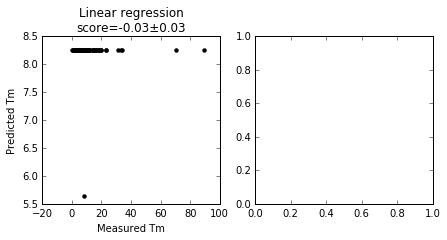

In [17]:
# now, let's train elastic net models for each feature set 

from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.cross_validation import StratifiedKFold
import numpy as np 

for name, feature_set in feature_sets:
    feature_set = tm.join( feature_set ).dropna()
    scl = preprocessing.StandardScaler()
    X = scl.fit_transform( feature_set.ix[ : , 1: ] )
    y = feature_set.ix[ : , 0 ]
    
    print name 

    n_folds = 2
    skf = StratifiedKFold( y, n_folds=n_folds, shuffle=False ) 

    plt.figure( figsize=(7, 3) )
    plt.subplot( 1, 2, 1 )
    scores = []
    for train, test in skf:
        reg = LinearRegression()
        reg.fit( X[ train ], y[ train ] ) 
        scores.append( reg.score( X[ test ], y[ test ] ) )
        preds = reg.predict( X[ test ] ) 

        plt.scatter( y[ test ], preds, c='k', lw=0 )
        plt.xlabel( 'Measured Tm' ) 
        plt.ylabel( 'Predicted Tm' )
    plt.title( u'Linear regression\nscore={}±{}'.format( np.mean( scores ).round(2), np.std( scores ).round(2) ) )
    
    scores = []
    plt.subplot( 1, 2, 2 )
    for train, test in skf:
        net = ElasticNetCV()
        net.fit( X[ train ], y[ train ] ) 
        scores.append( reg.score( X[ test ], y[ test ] ) )
        preds = net.predict( X[ test ] )
        
        plt.scatter( y[ test ], preds, c='k', lw=0 )

        plt.xlabel( 'Measured Tm' ) 
    plt.title( u'Elastic net\nscore={}±{}'.format( np.mean( scores ).round(2), np.std( scores ).round(2) ) )
    plt.show()

RosettaDesign


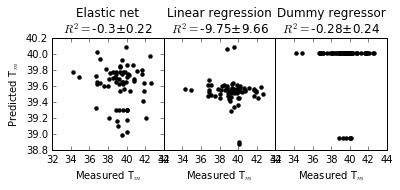

FoldX


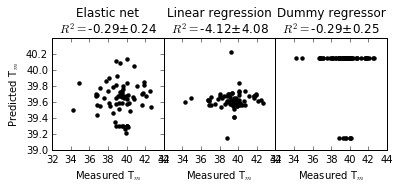

Rosetta ddG


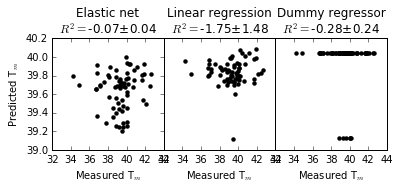

Rosetta FastRelax


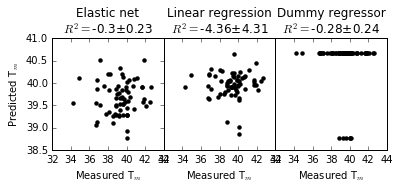

In [13]:
# now, let's train linear and elastic net models for each feature set 

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV, RANSACRegressor
from sklearn.cross_validation import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.dummy import DummyRegressor

classifiers = [ 
    ( 'Elastic net', ElasticNetCV() ), 
    ( 'Linear regression', LinearRegression(fit_intercept=True) ), 
    #( 'RANSAC with linear model', RANSACRegressor( LinearRegression() ) ), 
    ( 'Dummy regressor', DummyRegressor() ), 
] 

for name, feature_set in feature_sets:
    
    feature_set = tm.join( feature_set ).dropna()
    scl = StandardScaler()
    X = scl.fit_transform( feature_set.ix[ : , 1: ] )
    y = feature_set.ix[ : , 0 ]
    skf = StratifiedKFold( y, n_folds=2, shuffle=False, random_state=3 ) 
    
    print name 
    
    n_clf = len( classifiers ) 
    scl_factor = 2 
    plt.figure( figsize=(n_clf * scl_factor, scl_factor) )

    for idx, ( name, clf ) in enumerate( classifiers ):
        plt.subplot( 1, n_clf, idx+1 )
        preds = cross_val_predict( clf, X, y, cv=skf )
        scores = cross_val_score( clf, X, y, cv=skf, scoring='r2' )
        plt.scatter( y, preds, lw=0, c='k' ) 
        plt.title( u'{}\n$R^2=${}±{}'.format( name, scores.mean().round(2), scores.std().round(2) ) ) 
        #plt.xticks( [ 34, 38, 42 ] )
        plt.xlabel( 'Measured T$_m$' )
        #plt.xlim( [ 30, 46 ] ) 
        #plt.ylim( [ 30, 46 ] ) 
        
        if idx != 0:
            plt.yticks([]) 
        else:
            plt.ylabel( 'Predicted T$_m$' )
            #plt.yticks( [ 34, 38, 42 ] ) 
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

RosettaDesign


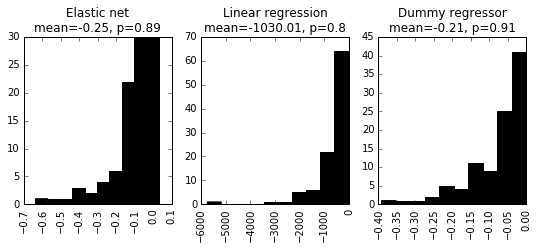

FoldX


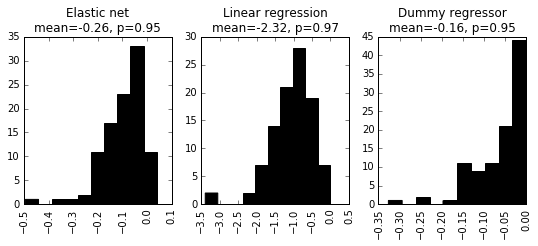

Rosetta ddG


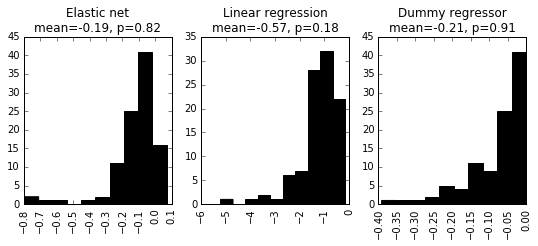

Rosetta FastRelax


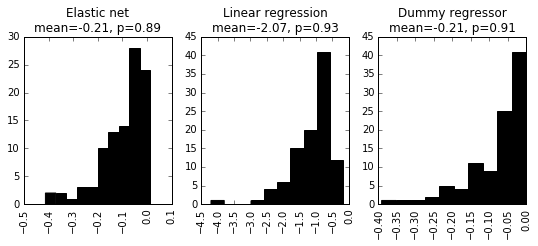

In [12]:
# permutation tests  

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, ElasticNetCV, RANSACRegressor
from sklearn.cross_validation import StratifiedKFold, cross_val_predict, cross_val_score, permutation_test_score
from sklearn.dummy import DummyRegressor

classifiers = [ 
    ( 'Elastic net', ElasticNetCV() ), 
    ( 'Linear regression', LinearRegression() ), 
    ( 'Dummy regressor', DummyRegressor() ), 
] 

for name, feature_set in feature_sets:
    
    feature_set = tm.join( feature_set ).dropna()
    scl = StandardScaler()
    X = scl.fit_transform( feature_set.ix[ : , 1: ] )
    y = feature_set.ix[ : , 0 ]
    skf = StratifiedKFold( y, n_folds=2, shuffle=False, random_state=3 ) 
    
    print name 
    
    n_clf = len( classifiers ) 
    scl_factor = 3 
    plt.figure( figsize=(n_clf * scl_factor, scl_factor) )

    for idx, ( name, clf ) in enumerate( classifiers ):
        plt.subplot( 1, n_clf, idx+1 )
        mean_score, scores, p_value = permutation_test_score( clf, X, y, scoring='r2', n_permutations=100 )
        
        plt.hist( scores, color='k' ) 
        plt.title( '{}\nmean={}, p={}'.format( name, mean_score.round( 2 ), p_value.round( 2 ) ) )
        plt.xticks( rotation=90 ) 
            
    #plt.subplots_adjust(wspace=0, hspace=0)

    plt.show()